In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import argparse
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
from tqdm import tqdm
from keras.datasets import mnist
import pandas as pd

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
def binary_sampler(p, rows, cols):
  '''Sample binary random variables.
  
  Args:
    - p: probability of 1
    - rows: the number of rows
    - cols: the number of columns
    
  Returns:
    - binary_random_matrix: generated binary random matrix.
  '''
  unif_random_matrix = np.random.uniform(0., 1., size = [rows, cols])
  binary_random_matrix = 1*(unif_random_matrix < p)
  return binary_random_matrix


def xavier_init(size):
  '''Xavier initialization.
  
  Args:
    - size: vector size
    
  Returns:
    - initialized random vector.
  '''
  in_dim = size[0]
  xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
  return tf.random_normal(shape = size, stddev = xavier_stddev)


def normalization (data, parameters=None):
  '''Normalize data in [0, 1] range..
  
  Args:
    - data: original data
  
  Returns:
    - norm_data: normalized data
    - norm_parameters: min_val, max_val for each feature for renormalization
  '''

  # Parameters
  _, dim = data.shape
  norm_data = data.copy()
  
  if parameters is None:
  
    # MixMax normalization
    min_val = np.zeros(dim)
    max_val = np.zeros(dim)
    
    # For each dimension
    for i in range(dim):
      min_val[i] = np.nanmin(norm_data[:,i])
      norm_data[:,i] = norm_data[:,i] - np.nanmin(norm_data[:,i])
      max_val[i] = np.nanmax(norm_data[:,i])
      norm_data[:,i] = norm_data[:,i] / (np.nanmax(norm_data[:,i]) + 1e-6)   
      
    # Return norm_parameters for renormalization
    norm_parameters = {'min_val': min_val,
                       'max_val': max_val}

  else:
    min_val = parameters['min_val']
    max_val = parameters['max_val']
    
    # For each dimension
    for i in range(dim):
      norm_data[:,i] = norm_data[:,i] - min_val[i]
      norm_data[:,i] = norm_data[:,i] / (max_val[i] + 1e-6)  
      
    norm_parameters = parameters    
      
  return norm_data, norm_parameters


def renormalization (norm_data, norm_parameters):
  '''Renormalize data from [0, 1] range to the original range.
  
  Args:
    - norm_data: normalized data
    - norm_parameters: min_val, max_val for each feature for renormalization
  
  Returns:
    - renorm_data: renormalized original data
  '''
  
  min_val = norm_parameters['min_val']
  max_val = norm_parameters['max_val']

  _, dim = norm_data.shape
  renorm_data = norm_data.copy()
    
  for i in range(dim):
    renorm_data[:,i] = renorm_data[:,i] * (max_val[i] + 1e-6)   
    renorm_data[:,i] = renorm_data[:,i] + min_val[i]
    
  return renorm_data


def rounding (imputed_data, data_x):
  '''Round imputed data for categorical variables.
  
  Args:
    - imputed_data: imputed data
    - data_x: original data with missing values
    
  Returns:
    - rounded_data: rounded imputed data
  '''
  
  _, dim = data_x.shape
  rounded_data = imputed_data.copy()
  
  for i in range(dim):
    temp = data_x[~np.isnan(data_x[:, i]), i]
    # Only for the categorical variable
    if len(np.unique(temp)) < 20:
      rounded_data[:, i] = np.round(rounded_data[:, i])
      
  return rounded_data


def uniform_sampler(low, high, rows, cols):
  '''Sample uniform random variables.
  
  Args:
    - low: low limit
    - high: high limit
    - rows: the number of rows
    - cols: the number of columns
    
  Returns:
    - uniform_random_matrix: generated uniform random matrix.
  '''
  return np.random.uniform(low, high, size = [rows, cols])       


def sample_batch_index(total, batch_size):
  '''Sample index of the mini-batch.
  
  Args:
    - total: total number of samples
    - batch_size: batch size
    
  Returns:
    - batch_idx: batch index
  '''
  total_idx = np.random.permutation(total)
  batch_idx = total_idx[:batch_size]
  return batch_idx

  
def rmse_loss (ori_data, imputed_data, data_m):
  '''Compute RMSE loss between ori_data and imputed_data
  
  Args:
    - ori_data: original data without missing values
    - imputed_data: imputed data
    - data_m: indicator matrix for missingness
    
  Returns:
    - rmse: Root Mean Squared Error
  '''
  
  ori_data, norm_parameters = normalization(ori_data)
  imputed_data, _ = normalization(imputed_data, norm_parameters)
    
  # Only for missing values
  nominator = np.sum(((1-data_m) * ori_data - (1-data_m) * imputed_data)**2)
  denominator = np.sum(1-data_m)
  
  rmse = np.sqrt(nominator/float(denominator))
  
  return rmse

In [3]:
def gain (data_x, gain_parameters):
  '''Impute missing values in data_x
  
  Args:
    - data_x: original data with missing values
    - gain_parameters: GAIN network parameters:
      - batch_size: Batch size 128
      - hint_rate: Hint rate  0.9
      - alpha: Hyperparameter  100
      - iterations: Iterations  10000
      
  Returns:
    - imputed_data: imputed data
  '''
  # Define mask matrix
  data_m = 1-np.isnan(data_x)
  
  # System parameters
  batch_size = gain_parameters['batch_size']
  hint_rate = gain_parameters['hint_rate']
  alpha = gain_parameters['alpha']
  iterations = gain_parameters['iterations']
  
  # Other parameters
  no, dim = data_x.shape
  
  # Hidden state dimensions
  h_dim = int(dim)
  
  # Normalization
  norm_data, norm_parameters = normalization(data_x)
  norm_data_x = np.nan_to_num(norm_data, 0)
  
  ## GAIN architecture   
  # Input placeholders
  # Data vector
  X = tf.placeholder(tf.float32, shape = [None, dim])
  # Mask vector 
  M = tf.placeholder(tf.float32, shape = [None, dim])
  # Hint vector
  H = tf.placeholder(tf.float32, shape = [None, dim])
  
  # Discriminator variables
  D_W1 = tf.Variable(xavier_init([dim*2, h_dim])) # Data + Hint as inputs
  D_b1 = tf.Variable(tf.zeros(shape = [h_dim]))
  
  D_W2 = tf.Variable(xavier_init([h_dim, h_dim]))
  D_b2 = tf.Variable(tf.zeros(shape = [h_dim]))
  
  D_W3 = tf.Variable(xavier_init([h_dim, dim]))
  D_b3 = tf.Variable(tf.zeros(shape = [dim]))  # Multi-variate outputs
  
  theta_D = [D_W1, D_W2, D_W3, D_b1, D_b2, D_b3]
  
  #Generator variables
  # Data + Mask as inputs (Random noise is in missing components)
  G_W1 = tf.Variable(xavier_init([dim*2, h_dim]))  
  G_b1 = tf.Variable(tf.zeros(shape = [h_dim]))
  
  G_W2 = tf.Variable(xavier_init([h_dim, h_dim]))
  G_b2 = tf.Variable(tf.zeros(shape = [h_dim]))
  
  G_W3 = tf.Variable(xavier_init([h_dim, dim]))
  G_b3 = tf.Variable(tf.zeros(shape = [dim]))
  
  theta_G = [G_W1, G_W2, G_W3, G_b1, G_b2, G_b3]
  
  ## GAIN functions
  # Generator
  def generator(x,m):
    # Concatenate Mask and Data
    inputs = tf.concat(values = [x, m], axis = 1) 
    G_h1 = tf.nn.relu(tf.matmul(inputs, G_W1) + G_b1)
    G_h2 = tf.nn.relu(tf.matmul(G_h1, G_W2) + G_b2)   
    # MinMax normalized output
    G_prob = tf.nn.sigmoid(tf.matmul(G_h2, G_W3) + G_b3) 
    return G_prob
  # Discriminator
  def discriminator(x, h):
    # Concatenate Data and Hint
    inputs = tf.concat(values = [x, h], axis = 1) 
    D_h1 = tf.nn.relu(tf.matmul(inputs, D_W1) + D_b1)  
    D_h2 = tf.nn.relu(tf.matmul(D_h1, D_W2) + D_b2)
    D_logit = tf.matmul(D_h2, D_W3) + D_b3
    D_prob = tf.nn.sigmoid(D_logit)
    return D_prob
  ## GAIN structure
  # Generator
  G_sample = generator(X, M)
  # Combine with observed data
  Hat_X = X * M + G_sample * (1-M) # Check the equation
  
  # Discriminator
  D_prob = discriminator(Hat_X, H)
  
  ## GAIN loss
  D_loss_temp = -tf.reduce_mean(M * tf.log(D_prob + 1e-8) \
                                + (1-M) * tf.log(1. - D_prob + 1e-8)) 
  
  G_loss_temp = -tf.reduce_mean((1-M) * tf.log(D_prob + 1e-8))

  MSE_loss = \
  tf.reduce_mean((M * X - M * G_sample)**2) / tf.reduce_mean(M)
  D_loss = D_loss_temp
  G_loss = G_loss_temp + alpha * MSE_loss 
  
  ## GAIN solver
  D_solver = tf.train.AdamOptimizer().minimize(D_loss, var_list=theta_D)
  G_solver = tf.train.AdamOptimizer().minimize(G_loss, var_list=theta_G)

  ## Iterations
  sess = tf.Session()
  sess.run(tf.global_variables_initializer())
   
  # Start Iterations
  for it in tqdm(range(iterations)):    
      
    # Sample batch
    batch_idx = sample_batch_index(no, batch_size)
    X_mb = norm_data_x[batch_idx,:]  
    M_mb = data_m[batch_idx, :]  
    # Sample random vectors  
    Z_mb = uniform_sampler(0, 0.01, batch_size, dim)
    # Sample hint vectors
    H_mb_temp = binary_sampler(hint_rate, batch_size, dim)
    H_mb = M_mb * H_mb_temp
      
    # Combine random vectors with observed vectors
    X_mb = M_mb * X_mb + (1-M_mb) * Z_mb 
      
    _, D_loss_curr = sess.run([D_solver, D_loss_temp], 
                              feed_dict = {M: M_mb, X: X_mb, H: H_mb})
    _, G_loss_curr, MSE_loss_curr = \
    sess.run([G_solver, G_loss_temp, MSE_loss],
             feed_dict = {X: X_mb, M: M_mb, H: H_mb})
            
  ## Return imputed data      
  Z_mb = uniform_sampler(0, 0.01, no, dim) 
  M_mb = data_m
  X_mb = norm_data_x          
  X_mb = M_mb * X_mb + (1-M_mb) * Z_mb 
      
  imputed_data = sess.run([G_sample], feed_dict = {X: X_mb, M: M_mb})[0]
  
  imputed_data = data_m * norm_data_x + (1-data_m) * imputed_data
  
  # Renormalization
  imputed_data = renormalization(imputed_data, norm_parameters)  
  
  # Rounding
  imputed_data = rounding(imputed_data, data_x)  
  return imputed_data

In [5]:
def data_loader (data_name, miss_rate):
  '''Loads datasets and introduce missingness.
  Args:
    - data_name: letter, spam, or mnist
    - miss_rate: the probability of missing components
  Returns:
    data_x: original data
    miss_data_x: data with missing values
    data_m: indicator matrix for missing components
  '''
  # Load data
  if data_name in ['dataset4', 'spam']:
    file_name = data_name+'.csv'
    data_x = np.loadtxt(file_name, delimiter=",", skiprows=1)
  elif data_name == 'mnist':
    (data_x, _), _ = mnist.load_data()
    data_x = np.reshape(np.asarray(data_x), [60000, 28*28]).astype(float)

  # Parameters
  no, dim = data_x.shape
  print(no)
  # Introduce missing data
  data_m = binary_sampler(1-miss_rate, no, dim)
  miss_data_x = data_x.copy()
  miss_data_x[data_m == 0] = np.nan  # data missingness
      
  return data_x, miss_data_x, data_m

In [7]:
def main (data_name,miss_rate,batch_size,hint_rate,alpha,iterations): 
  #data_name = args.data_name
  #miss_rate = args.miss_rate
  
  gain_parameters = {'batch_size': batch_size,
                     'hint_rate':  hint_rate,
                     'alpha':  alpha,
                     'iterations': iterations}
  # Load data and introduce missingness
  ori_data_x, miss_data_x, data_m = data_loader(data_name, miss_rate)
  
  # Impute missing data
  imputed_data_x = gain(miss_data_x, gain_parameters)
  
  # Report the RMSE performance
  rmse = rmse_loss (ori_data_x, imputed_data_x, data_m)
  
  print()
  print('RMSE Performance: ' + str(np.round(rmse, 4)))
  
  return imputed_data_x, rmse

In [8]:
imputed_data, rmse = main('dataset4',0.2,128,0.9,100,10000)

4129


100%|██████████| 10000/10000 [00:19<00:00, 525.87it/s]


RMSE Performance: 0.2898


In [9]:
DF = pd.DataFrame(imputed_data)
DF.to_csv("imputed_dataset4.csv")

In [10]:
df = pd.read_csv("imputed_dataset4.csv")

In [11]:
df

,Unnamed: 0,0,1
0,0,2.245438,3.393696
1,1,2.245438,3.948891
2,2,0.000000,3.394773
3,3,0.000000,3.395056
4,4,2.245438,3.948891
...,...,...,...
4124,4124,3.018942,4.400018
4125,4125,3.022064,4.400045
4126,4126,3.025058,4.399933
4127,4127,3.027931,4.400000


In [12]:
import matplotlib.pyplot as plt

In [13]:
df1=pd.read_csv("dataset4.csv")
df2=pd.read_csv("imputed_dataset4.csv")

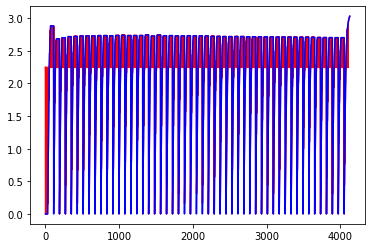

In [14]:
plt.plot(df2['0'],color ='r', 
         label ='Charge_capacity_Imputed')
plt.plot(df1['Charge_Capacity(Ah)'],color='blue',label="Charge_Real")
plt.savefig('Charge_dataset4.pdf')

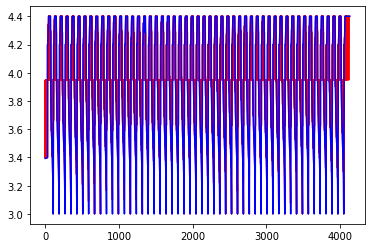

In [15]:
plt.plot(df2['1'],color ='r', 
         label ='Voltage_Imputed')
plt.plot(df1['Voltage(V)'],color='blue',label="VoltageReal")
plt.savefig('Voltage_Dataset4.pdf')

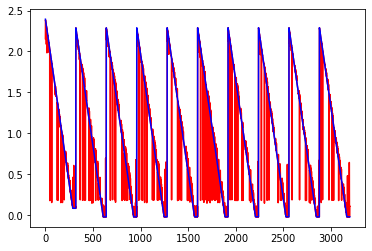

In [ ]:
plt.plot(df2['2'],color ='r', 
         label ='AhImputed')
plt.plot(df1['Ah'],color='blue',label="AhReal")
plt.savefig('Ah.pdf')